## **Importing libraries -**

In [1]:
import sys
import gc
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install pytorch_toolbelt

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-en8fdvne
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-en8fdvne
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 1fa49d0953708c0a61ab11c5cc4052d20909a9bc
  Installing build dependencies ... - \ | / - \ done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 766.5 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 2.9 MB/s eta 0:00:00
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.3.0-py3-none-any.whl size=102059 sha256=e19baeddba985905b78780fa328e793fa22c8b7faf0c6bfdb83411414ee766b2
  Stored in directory: /tmp/pip-ephem-wh

In [2]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
import pickle

import cv2
from PIL import Image
from tqdm.notebook import tqdm

import albumentations as A

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torchvision.transforms import ToTensor

import segmentation_models_pytorch as smp
from pytorch_toolbelt import losses as L

from sklearn.model_selection import train_test_split

## **Importing and exploring data -**

In [3]:
base_path = "../input/ann-segmentation-m2"

In [4]:
train_img_paths = []
for i in range(1, 8):
    for img_name in os.listdir(os.path.join(base_path, f"train_images_{i}/train_images_{i}")):
        train_img_paths.append(os.path.join(base_path, f"train_images_{i}/train_images_{i}", img_name))
        
# below mapping function gets the mask path from the image path
mapping_func = lambda x: os.path.join(base_path, "train_masks/train_masks", x.split(".jpg")[0].split("/")[-1]+".png")

In [5]:
test_img_paths = []
for img_name in os.listdir(os.path.join(base_path, "test_images/test_images")):
    test_img_paths.append(os.path.join(base_path, "test_images/test_images", img_name))

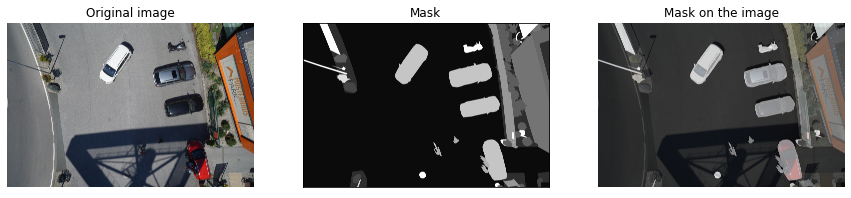

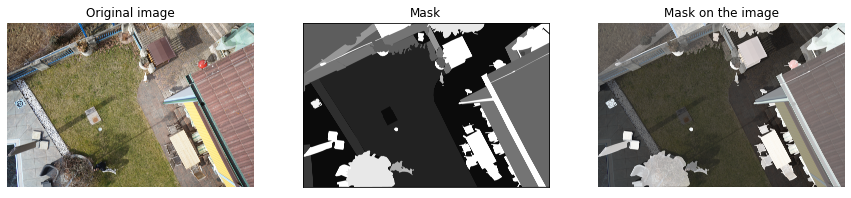

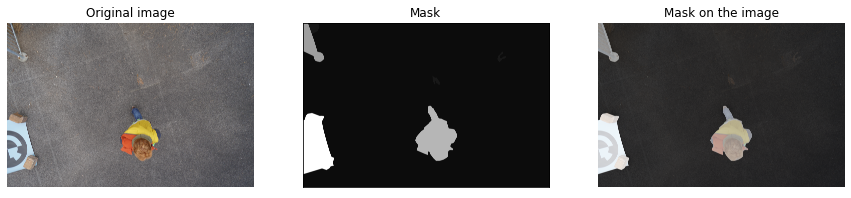

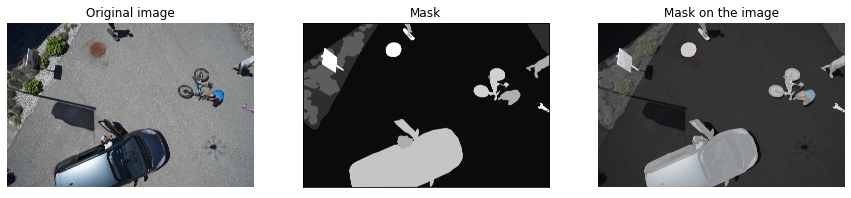

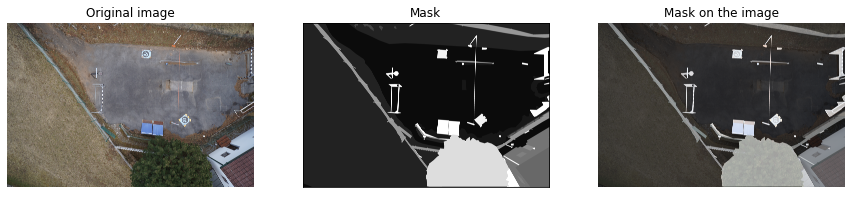

In [6]:
# Plotting 5 random images with their masks -
req_egs = 5
rand_imgs = random.sample(train_img_paths, req_egs)
rand_masks = list(map(mapping_func, rand_imgs))

for i in range(req_egs):
    fig = plt.figure(figsize=(15, 10))
    
    img = np.array(Image.open(rand_imgs[i]).convert('RGB'))
    mask = cv2.imread(rand_masks[i], cv2.IMREAD_GRAYSCALE)
    
    a = fig.add_subplot(1, 3, 1)
    plt.imshow(img, cmap='bone')
    a.set_title("Original image")
    plt.grid(False)
    plt.axis("off")
    
    a = fig.add_subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray') 
    a.set_title("Mask")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    a = fig.add_subplot(1, 3, 3)
    plt.imshow(img, cmap='bone')
    plt.imshow(mask, cmap='gray', alpha=0.7)
    a.set_title("Mask on the image")
    
    plt.axis("off")

    plt.grid(False)

## **Creating a dataframe containing the image path, corresponding mask path and corresponding label (0 or 1 for each class) indicating whether that class is present or absent in the image -**

In [7]:
#num_classes = 20
col_names = ['img_path', 'mask_path']
#col_names.extend([f'class_{i}' for i in range(1, num_classes+1)])
drone_df = pd.DataFrame(index=range(len(train_img_paths)), columns=col_names)
drone_df.head(3)

,img_path,mask_path
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN


In [8]:
"""unq_classes = []
for img_path in tqdm(train_img_paths):
    mask = np.array(Image.open(mapping_func(img_path)).convert('RGB'))
    del(img_path)
    mask = np.transpose(mask, (2, 0, 1))
    a = pd.Series(mask[0].flatten()).astype('str')
    b = pd.Series(mask[1].flatten()).astype('str')
    c = pd.Series(mask[2].flatten()).astype('str')
    del(mask)
    unq_classes.append(list((a + " " + b + " " + c).unique()))
    del(a, b, c)
    gc.collect()"""

'unq_classes = []\nfor img_path in tqdm(train_img_paths):\n    mask = np.array(Image.open(mapping_func(img_path)).convert(\'RGB\'))\n    del(img_path)\n    mask = np.transpose(mask, (2, 0, 1))\n    a = pd.Series(mask[0].flatten()).astype(\'str\')\n    b = pd.Series(mask[1].flatten()).astype(\'str\')\n    c = pd.Series(mask[2].flatten()).astype(\'str\')\n    del(mask)\n    unq_classes.append(list((a + " " + b + " " + c).unique()))\n    del(a, b, c)\n    gc.collect()'

In [9]:
"""with open('img_classes.pickle', 'wb') as f:
    pickle.dump(unq_classes, f)"""

"with open('img_classes.pickle', 'wb') as f:\n    pickle.dump(unq_classes, f)"

In [10]:
drone_df['img_path'] = train_img_paths
drone_df['mask_path'] = list(map(mapping_func, train_img_paths))

In [11]:
df_train, df_val = train_test_split(drone_df, test_size=0.20, random_state=0)
df_train.shape, df_val.shape

((280, 2), (70, 2))

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = pd.DataFrame(test_img_paths, columns=['img_path'])

## **Defining config, plotting function and augmentations -**

In [13]:
CONFIG = {
    'IMG_HEIGHT': 416,
    'IMG_WIDTH': 608,
    'EPOCHS': 25,
    'PATIENCE': 3,
    'LEARNING_RATE': 5e-5,
    'BATCH_SIZE': 16,
    'LRd_FACTOR': 0.1, # learning rate decay factor
    'LRd_PERIOD': 4, # learning rate decay period
    'DEVICE': torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
}

### NOTE - Image height and width considered above are divisible by 32 (required for U-Net model) while maintaining the aspect ratio(height:width = 2:3) of the original images as much as possible. Images have been resized to lower dimensions due to compute constraints.

In [14]:
def plot_results(train_loss, valid_loss):
    epochs = [i for i in range(1, len(train_loss)+1)]
    
    fig = plt.figure(figsize=(14,7))
    
    plt.plot(epochs, train_loss, 'go-', label='Training Loss')
    plt.plot(epochs, valid_loss, 'ro-', label='Validation Loss')
    plt.title('Training & Validation (avg losses)')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.show()

In [15]:
augments = {
    'train': A.Compose([
        A.PadIfNeeded(min_height=CONFIG['IMG_HEIGHT'], min_width=CONFIG['IMG_WIDTH'], p=1),
        A.Resize(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'], p = 1.0)
        #A.RandomResizedCrop(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE']),    
    ], p=1.0),
    
    'val': A.Compose([
        A.PadIfNeeded(min_height=CONFIG['IMG_HEIGHT'], min_width=CONFIG['IMG_WIDTH'], p=1),
        #A.CenterCrop(CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'], p=1.0),
        A.Resize(CONFIG['IMG_HEIGHT'], CONFIG['IMG_WIDTH'], p = 1.0)
        ], p=1.0)
    }

## **Creating a custom Dataset class -**

In [16]:
class DroneDataset(Dataset):
    def __init__(self, df, transform, preprocessing_fn, targets_known=True):
        super(DroneDataset, self).__init__()
        self.df = df
        self.transform = transform
        self.preprocessing_fn = preprocessing_fn
        self.targets_known = targets_known
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = np.array(Image.open(self.df['img_path'][idx]).convert('RGB'))
        
        if self.targets_known:
            mask = cv2.imread(self.df['mask_path'][idx], cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            if self.targets_known:
                transformed = self.transform(image=img, mask=mask)
                img, mask = transformed['image'], transformed['mask']
                mask = (mask / 255.0)
            else:
                img = self.transform(image=img)['image']
                
        if self.preprocessing_fn:
            img = self.preprocessing_fn(img)   # smp library preprocessing function
            
        if self.targets_known:
            img, mask = ToTensor()(img), ToTensor()(mask).float()
            return img, mask
        
        img = ToTensor()(img)
        return img

## **Creating dataloaders and defining the model -**

In [17]:
data_dirs = ['train', 'val', 'test']

prep_fn = smp.encoders.get_preprocessing_fn('resnet34', pretrained='imagenet')

img_datasets = {
'train': DroneDataset(df_train, augments['train'], prep_fn),
'val': DroneDataset(df_val, augments['val'], prep_fn),
'test': DroneDataset(df_test, augments['val'], prep_fn, targets_known=False)
}

img_dataloaders = {
'train': DataLoader(img_datasets['train'], batch_size=CONFIG['BATCH_SIZE'], shuffle=True, pin_memory=False, drop_last=True, num_workers=2),
'val': DataLoader(img_datasets['val'], batch_size=CONFIG['BATCH_SIZE'], shuffle=False, pin_memory=False, drop_last=False, num_workers=2),
'test': DataLoader(img_datasets['test'], batch_size=CONFIG['BATCH_SIZE'], shuffle=False, pin_memory=False, drop_last=False, num_workers=2)
}

dataset_sizes = {x: len(img_datasets[x]) for x in data_dirs}

In [18]:
for i, j in img_dataloaders['train']:
    print(i.shape, j.shape)
    break

torch.Size([16, 3, 416, 608]) torch.Size([16, 1, 416, 608])


In [19]:
unet_model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                     # model output channels
    encoder_depth=5,                # number of downsampling i.e. max pooling operations in the encoder
    decoder_channels=[256,128,64,32,16],    # list of input_channels to the convolution operations in the decoder
    activation='sigmoid'
).to(CONFIG['DEVICE'])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

## **Defining train and eval functions -**

In [20]:
def train_model(model, loss_fn, scaler, optimizer, scheduler, num_epochs = CONFIG['EPOCHS'], patience = CONFIG['PATIENCE']):
    best_model_wts = copy.deepcopy(model.state_dict())
    lowest_val_loss, best_model_epoch = float('inf'), 0
    rounds_no_improve = 0 # num of consecutive rounds in which validation loss didn't improve
    train_losses, val_losses = [], []
    
    for epoch in range(num_epochs):
        print(f"{'-'*45} EPOCH: {epoch + 1}/{num_epochs} {'-'*45}")
        model.train()
        running_loss = 0
        train_prog_bar = tqdm(img_dataloaders['train'], total = len(img_dataloaders['train']))
        for batch_X, batch_y in train_prog_bar:
            batch_X, batch_y = batch_X.to(CONFIG['DEVICE'], dtype=torch.float), batch_y.to(CONFIG['DEVICE'], dtype=torch.long)
            optimizer.zero_grad()
            with autocast():
                outputs = model(batch_X)
                batch_loss = loss_fn(outputs, batch_y)
            scaler.scale(batch_loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += batch_loss.detach().item()

            train_pbar_desc = f'loss: {batch_loss.detach().item():.4f}'
            train_prog_bar.set_description(desc = train_pbar_desc)
        scheduler.step()
        avg_batch_loss = running_loss / len(img_dataloaders['train'])
        train_losses.append(avg_batch_loss)
        print(f"Avg batch loss(train): {avg_batch_loss:.4f}")
        del batch_X, batch_y, outputs
        
        val_loss = eval_model(model, loss_fn)
        val_losses.append(val_loss)
        
        if epoch > 0:
            if round(val_loss, 4) >= round(lowest_val_loss, 4):
                rounds_no_improve += 1
            else:
                rounds_no_improve = 0
            if rounds_no_improve == patience:
                break
        
        if round(val_loss, 4) < round(lowest_val_loss, 4):
            lowest_val_loss = val_loss
            best_model_epoch = epoch + 1
            best_model_wts = copy.deepcopy(model.state_dict())
            
        torch.cuda.empty_cache()
    
    print("\n")
    print("Best model -")
    print(f"Epoch: {best_model_epoch}")
    model.load_state_dict(best_model_wts)
    lowest_train_loss = eval_model(model, loss_fn, for_data = 'train')    
    print(f"Train loss: {lowest_train_loss}")
    print(f"Validation loss: {lowest_val_loss}")
    return (model, train_losses, val_losses)

In [21]:
def eval_model(model, loss_fn, for_data = 'val'):
    model.eval()
    running_loss = 0
    eval_prog_bar = tqdm(img_dataloaders[for_data], total = len(img_dataloaders[for_data]))
    with torch.no_grad():
        for batch_X, batch_y in eval_prog_bar:
            batch_X, batch_y = batch_X.to(CONFIG['DEVICE'], dtype=torch.float), batch_y.to(CONFIG['DEVICE'], dtype=torch.long)
            outputs = model(batch_X)
            batch_loss = loss_fn(outputs, batch_y)
            running_loss += batch_loss.detach().item()
            eval_pbar_desc = f'loss: {batch_loss.detach().item():.4f}'
            eval_prog_bar.set_description(desc = eval_pbar_desc)
        del batch_X, batch_y, outputs
        
        avg_batch_loss = running_loss / len(img_dataloaders[for_data])
        if for_data == 'val':
            print(f"Avg batch loss(val): {avg_batch_loss:.4f}")
        return avg_batch_loss

## **Training the model -**

### NOTE - Model is optimized to reduce the Dice Loss and that controls for how long the model is going to be trained.

--------------------------------------------- EPOCH: 1/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.2848


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.3878
--------------------------------------------- EPOCH: 2/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.2342


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.2314
--------------------------------------------- EPOCH: 3/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1912


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1656
--------------------------------------------- EPOCH: 4/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1552


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1456
--------------------------------------------- EPOCH: 5/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1399


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1419
--------------------------------------------- EPOCH: 6/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1383


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1400
--------------------------------------------- EPOCH: 7/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1360


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1375
--------------------------------------------- EPOCH: 8/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1340


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1357
--------------------------------------------- EPOCH: 9/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1329


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1353
--------------------------------------------- EPOCH: 10/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1325


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1350
--------------------------------------------- EPOCH: 11/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1331


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1352
--------------------------------------------- EPOCH: 12/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1322


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1347
--------------------------------------------- EPOCH: 13/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1319


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1354
--------------------------------------------- EPOCH: 14/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1325


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1352
--------------------------------------------- EPOCH: 15/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1324


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1344
--------------------------------------------- EPOCH: 16/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1320


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1346
--------------------------------------------- EPOCH: 17/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1322


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1343
--------------------------------------------- EPOCH: 18/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1324


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1347
--------------------------------------------- EPOCH: 19/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1331


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1346
--------------------------------------------- EPOCH: 20/25 ---------------------------------------------


  0%|          | 0/17 [00:00<?, ?it/s]

Avg batch loss(train): 0.1319


  0%|          | 0/5 [00:00<?, ?it/s]

Avg batch loss(val): 0.1349


Best model -
Epoch: 17


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss: 0.13099470559288473
Validation loss: 0.13431936502456665




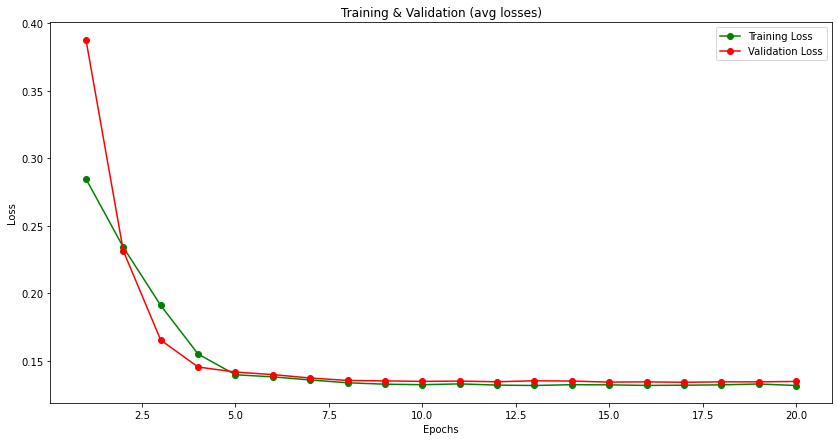

In [22]:
loss_fn = smp.losses.DiceLoss(mode='multiclass', from_logits=False)

scaler = GradScaler()
#params_list = list(unet_model.decoder.parameters()) + list(unet_model.segmentation_head.parameters())
optimizer = optim.Adam(unet_model.parameters(), lr = CONFIG['LEARNING_RATE'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = CONFIG['LRd_PERIOD'], gamma = CONFIG['LRd_FACTOR'])

best_model, train_losses, val_losses = train_model(unet_model, loss_fn, scaler, optimizer, scheduler)
print("\n")
plot_results(train_losses, val_losses)

In [23]:
PATH = "UNet_ResNet34.pth"
torch.save(best_model.state_dict(), PATH)